In [1]:
import os
import sys
from copy import deepcopy

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import torch
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from training.dataset.transforms import ComposeAPI, NormalizeAPI
from tqdm import tqdm

from dataset.collate_fn import collate_fn
from dataset.mini_dataset import MiniDataset

/home/guests/tuna_gurbuz/prototype


In [2]:
# Dataset
object_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 24, 25, 26, 27, 28, 29]
len_video = 1
input_image_size = 512
batch_size = 1
shuffle = False
multiview = True
mean = [0.3551, 0.3500, 0.3469]
std = [0.2921, 0.2716, 0.2742]
transforms = [ComposeAPI([NormalizeAPI(mean=mean, std=std, v2=True)])]
revert_mean=[-.3551/.2921, -.3500/.2716, -.3469/.2742]
revert_std=[1/.2921, 1/.2716, 1/.2742]
revert_transform = Normalize(mean=revert_mean, std=revert_std)
test_dataset = MiniDataset('train',
                           num_frames=len_video,
                           input_image_size=input_image_size,
                           object_labels=object_labels,
                           transforms=transforms,
                           collate_fn=collate_fn,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           multiview=multiview,)
print(f'Lenght of the dataset! {len(test_dataset)}')

Loading the take 001_PKA!


5683it [00:04, 1334.99it/s]


Mutual IDs: 1799
Loading the take 003_TKA!


5076it [00:03, 1428.47it/s]


Mutual IDs: 994
Loading the take 005_TKA!


4737it [00:00, 14251.88it/s]


Loading the take 006_PKA!


3706it [00:02, 1451.47it/s]


Mutual IDs: 981
Loading the take 008_PKA!


3513it [00:02, 1329.41it/s]


Mutual IDs: 2679
Loading the take 010_PKA!


2830it [00:01, 2728.34it/s] 


Mutual IDs: 1296
Loading the take 012_1_PKA!


1526it [00:01, 1347.04it/s]


Mutual IDs: 256
Loading the take 035_PKA!


5653it [00:04, 1294.25it/s]


Mutual IDs: 1107
Loading the take 037_TKA!


4237it [00:02, 1671.53it/s]


Lenght of the dataset! 9112


In [3]:
cam_int_ext = [(mtrx[0].numpy(), mtrx[1].numpy()) for mtrx in test_dataset.camera_features['001_PKA']]
cam_int = [mtrx[0] for mtrx in cam_int_ext]
cam_ext = [mtrx[1] for mtrx in cam_int_ext]

In [4]:
def process_img(mv_idx, img_indices):
    # Get image path
    img_paths = test_dataset.images[img_indices, :].squeeze(1)  # get image paths for the multiview indices
    # Load video data batch
    video_data_batch = test_dataset[mv_idx]
    # Inverse mean std normalization
    img0 = revert_transform(video_data_batch[0][0].frames[0].data).numpy()
    img1 = revert_transform(video_data_batch[0][1].frames[0].data).numpy()
    img2 = revert_transform(video_data_batch[0][2].frames[0].data).numpy()
    img = (img0, img1, img2)
    # Depth path
    depth_images = []
    for img_path in img_paths:
        last_part = str(img_path.parts[-1].split('/')[-1].replace('.jpg', '.tiff').replace('color', 'depth'))
        depth_path = img_path.parents[1] / 'depthimage' / last_part
        # Load depth image
        gt_depth_image = Image.open(depth_path)
        # Resize depth image to 512x512
        gt_depth_image = gt_depth_image.resize((gt_depth_image.size[0]//2, gt_depth_image.size[1]//2))
        depth_images.append(np.array(gt_depth_image))
    return img, depth_images, depth_path, video_data_batch

In [5]:
len_dataset = len(test_dataset)
print(f'Length of the dataset: {len_dataset}')
mv_indices = [1115]  # [700, 1115, 1442]
img_views = []
depth_views = []

for mv_idx in tqdm(mv_indices):
    # Get image path and camera index
    img_indices = [mv_idx * 3 + kk for kk in range(3)]
    img, gt_depth_image, depth_path, video_data_batch = process_img(mv_idx, img_indices)
    img = np.stack(img, axis=0)  # Stack images along a new dimension
    gt_depth_image = np.stack(gt_depth_image, axis=0)  # Stack depth images along a new dimension
    H,W = gt_depth_image.shape[-2:]
    buffer = (W-H) // 2
    img = img[:,:, buffer:-buffer, :]
    assert img.shape[-2:] == gt_depth_image.shape[-2:]
    img_views.append(img)
    depth_views.append(gt_depth_image)

Length of the dataset: 9112


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009252468..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0049556065..1.0000001].


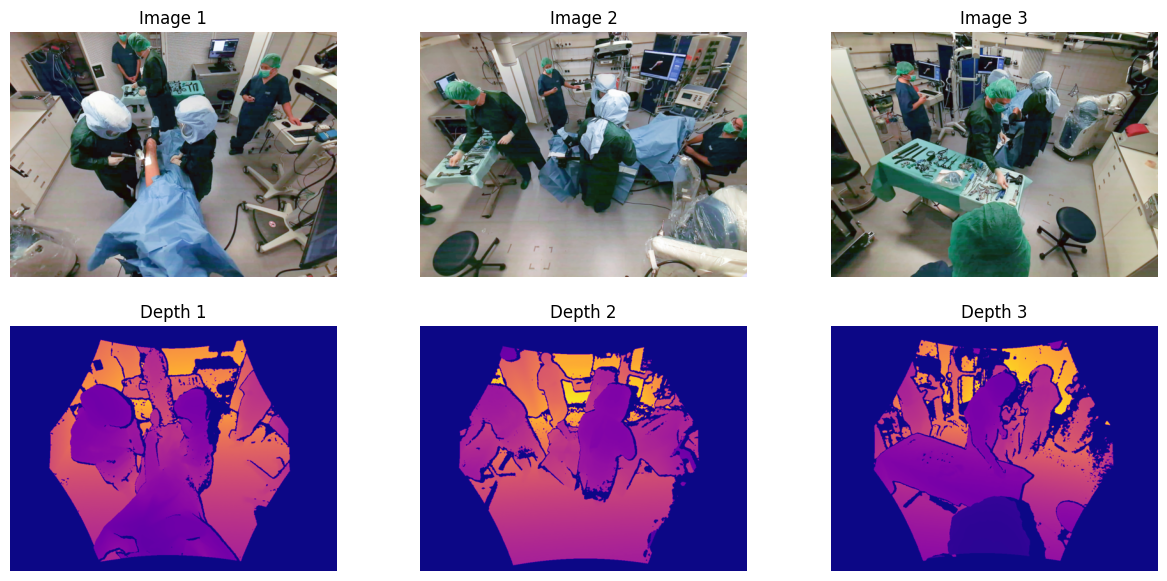

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
for i, im in enumerate(img):
    axs[0, i].imshow(im.transpose(1, 2, 0))  # Change to HxWxC for plotting
    axs[0, i].set_title(f'Image {i+1}')
    axs[0, i].axis('off')
    
    axs[1, i].imshow(gt_depth_image[i], cmap='plasma')  # Change to HxW for plotting
    axs[1, i].set_title(f'Depth {i+1}')
    axs[1, i].axis('off')

In [7]:
obj_id = 9
mask0 = video_data_batch[0][0].frames[0].objects[obj_id].segment
mask1 = video_data_batch[0][1].frames[0].objects[obj_id].segment
mask2 = video_data_batch[0][2].frames[0].objects[obj_id].segment

(-0.5, 511.5, 383.5, -0.5)

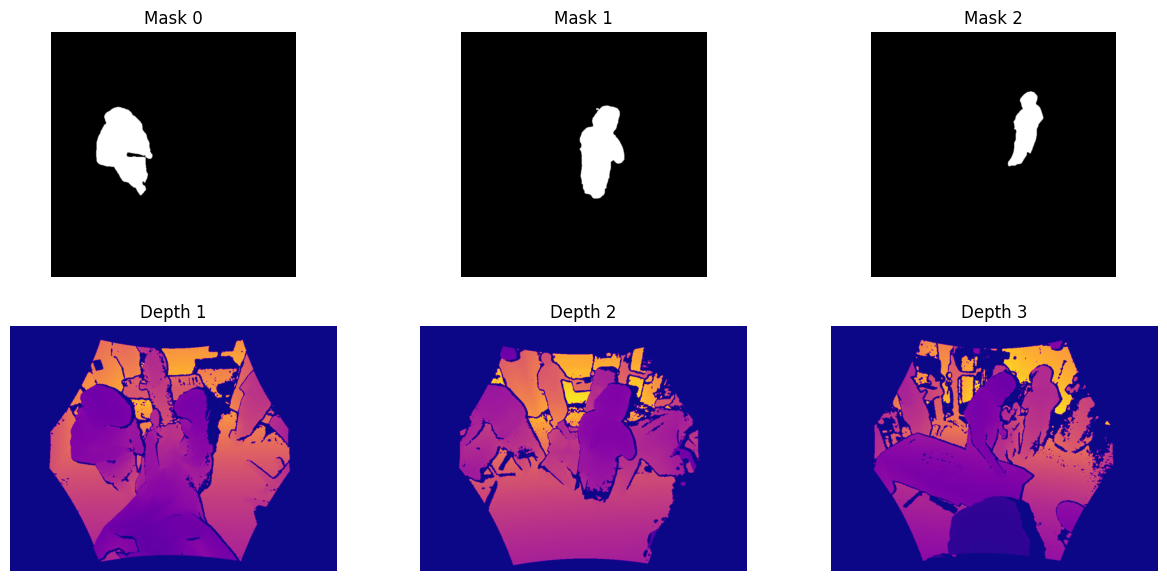

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
axs[0, 0].imshow(mask0.squeeze().numpy(), cmap='gray')
axs[0, 1].imshow(mask1.squeeze().numpy(), cmap='gray')
axs[0, 2].imshow(mask2.squeeze().numpy(), cmap='gray')
axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[0, 2].axis('off')
axs[0, 0].set_title('Mask 0')
axs[0, 1].set_title('Mask 1')
axs[0, 2].set_title('Mask 2')

axs[1, 0].imshow(gt_depth_image[0], cmap='plasma')  # Change to HxW for plotting
axs[1, 1].imshow(gt_depth_image[1], cmap='plasma')  # Change to HxW for plotting
axs[1, 2].imshow(gt_depth_image[2], cmap='plasma')  # Change to HxW for plotting
axs[1, 0].set_title('Depth 1')
axs[1, 1].set_title('Depth 2')
axs[1, 2].set_title('Depth 3')
axs[1, 0].axis('off')
axs[1, 1].axis('off')
axs[1, 2].axis('off')

Cropped Mask

In [9]:
padding = 64
depth_trunc = 10 * 1e3

work_on_cropped_image = False
if work_on_cropped_image:
    cropped_mask0 = mask0.squeeze().numpy()[padding:-padding]
    cropped_mask1 = mask1.squeeze().numpy()[padding:-padding]
    cropped_mask2 = mask2.squeeze().numpy()[padding:-padding]

    y0_, x0_ = np.where(cropped_mask0 > 0)
    y1_, x1_ = np.where(cropped_mask1 > 0)
    y2_, x2_ = np.where(cropped_mask2 > 0)

    mask0_depth = gt_depth_image[0].squeeze()[y0_, x0_]
    mask1_depth = gt_depth_image[1].squeeze()[y1_, x1_]
    mask2_depth = gt_depth_image[2].squeeze()[y2_, x2_]

    mask0_depth[mask0_depth > depth_trunc] = depth_trunc
    mask1_depth[mask1_depth > depth_trunc] = depth_trunc
    mask2_depth[mask2_depth > depth_trunc] = depth_trunc
else:
    cropped_mask0 = mask0.squeeze().numpy()
    cropped_mask1 = mask1.squeeze().numpy()
    cropped_mask2 = mask2.squeeze().numpy()

    y0_, x0_ = np.where(cropped_mask0 > 0)
    y1_, x1_ = np.where(cropped_mask1 > 0)
    y2_, x2_ = np.where(cropped_mask2 > 0)
    
    mask0_depth = np.zeros_like(cropped_mask0, dtype=float)
    mask1_depth = np.zeros_like(cropped_mask1, dtype=float)
    mask2_depth = np.zeros_like(cropped_mask2, dtype=float)

    mask0_depth[padding:-padding] = gt_depth_image[0]
    mask1_depth[padding:-padding] = gt_depth_image[1]
    mask2_depth[padding:-padding] = gt_depth_image[2]

    mask0_depth = mask0_depth.squeeze()[y0_, x0_]
    mask1_depth = mask1_depth.squeeze()[y1_, x1_]
    mask2_depth = mask2_depth.squeeze()[y2_, x2_]

    mask0_depth[mask0_depth > depth_trunc] = depth_trunc
    mask1_depth[mask1_depth > depth_trunc] = depth_trunc
    mask2_depth[mask2_depth > depth_trunc] = depth_trunc

In [10]:
K0, K1, K2 = cam_int[0], cam_int[1], cam_int[2]
T0, T1, T2 = cam_ext[0], cam_ext[1], cam_ext[2]  # Transformations are from camera to world coordinates

if work_on_cropped_image:
    K0[1,2] -= padding
    K1[1,2] -= padding
    K2[1,2] -= padding

print(f'Intrinsics: {K0},\n{K1},\n{K2}')

Intrinsics: [[244.37224   0.      255.61455]
 [  0.      244.26659 259.83765]
 [  0.        0.        1.     ]],
[[243.71532   0.      254.75685]
 [  0.      243.67114 257.7462 ]
 [  0.        0.        1.     ]],
[[243.6997    0.      256.37357]
 [  0.      243.69447 256.52545]
 [  0.        0.        1.     ]]


DEBUG

In [11]:
# debug0 = np.zeros_like(cropped_mask0)
# debug1 = np.zeros_like(cropped_mask1)
# debug2 = np.zeros_like(cropped_mask2)

# debug0[y0_, x0_] = mask0_depth
# debug1[y1_, x1_] = mask1_depth
# debug2[y2_, x2_] = mask2_depth

# plt.imshow(debug0, cmap='plasma')
# plt.imshow(debug1, cmap='plasma')
# plt.imshow(debug2, cmap='plasma')

Point Cloud Computation

In [12]:
h_coords0 = np.stack([x0_, y0_, np.ones_like(x0_)], axis=1)  # Homogeneous coordinates Nx3
h_coords1 = np.stack([x1_, y1_, np.ones_like(x1_)], axis=1)  # Homogeneous coordinates Nx3
h_coords2 = np.stack([x2_, y2_, np.ones_like(x2_)], axis=1)  # Homogeneous coordinates Nx3

im_coords0 = np.linalg.inv(K0) @ h_coords0.T  # Inverse camera matrix multiplication 3xN
im_coords1 = np.linalg.inv(K1) @ h_coords1.T  # Inverse camera matrix multiplication 3xN
im_coords2 = np.linalg.inv(K2) @ h_coords2.T  # Inverse camera matrix multiplication 3xN

In [13]:
im_coords0_depth_scaled = im_coords0 * mask0_depth / 1000.0
im_coords1_depth_scaled = im_coords1 * mask1_depth / 1000.0
im_coords2_depth_scaled = im_coords2 * mask2_depth / 1000.0

obj_pc0 = T0 @ np.concatenate([im_coords0_depth_scaled, np.ones_like(x0_)[None,:]], axis=0)  # Transforming to world coordinates 4xN
obj_pc1 = T1 @ np.concatenate([im_coords1_depth_scaled, np.ones_like(x1_)[None,:]], axis=0)  # Transforming to world coordinates 4xN
obj_pc2 = T2 @ np.concatenate([im_coords2_depth_scaled, np.ones_like(x2_)[None,:]], axis=0)  # Transforming to world coordinates 4xN

# obj_pc = np.concatenate([obj_pc0, obj_pc1, obj_pc2], axis=1)
obj_pc = np.concatenate([obj_pc1, obj_pc2], axis=1)

In [14]:
_flag_dump = False
if _flag_dump:
    with open(f'../temp/pc_test_obj_{obj_id}.npy', 'wb') as f:
        np.save(f, np.array(obj_pc))

Projection to 1st Frame

In [15]:
projected_pts0 = K0 @ (np.linalg.inv(T0) @ obj_pc)[:3, :]  # Projecting back to image coordinates 3xN
normalized_pts0 = projected_pts0 / projected_pts0[2, :]
pixel_pts0 = normalized_pts0[:2, :]  # Pixel coordinates 2xN
pixel_pts0 = pixel_pts0.round().astype(int)  # Round to nearest integer for pixel coordinates

(-0.5, 511.5, 511.5, -0.5)

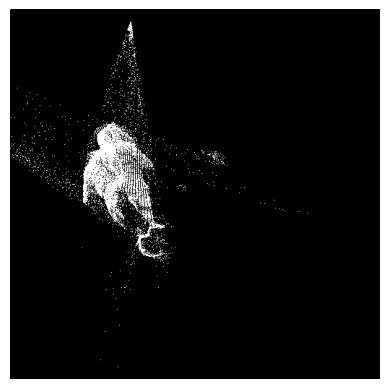

In [22]:
H, W = cropped_mask0.shape
mask = np.zeros([H, W])
refinement = (pixel_pts0[1] > (H-1)) | (pixel_pts0[1] < 0) | (pixel_pts0[0] > (W-1)) | (pixel_pts0[0] < 0)
pixel_pts0[:, refinement] = 0  # Set invalid pixel coordinates to 0
mask[pixel_pts0[1], pixel_pts0[0]] = 1  # Create a mask for the first image
plt.imshow(mask, cmap='gray')
plt.axis('off')

Test Point Cloud Main Code

In [17]:
from custom_models.models.sam2former.point_cloud_mask import point_cloud_mask

In [18]:
gt_depth_image_test = [torch.tensor(gt_depth_image[0][None,:]), torch.tensor(gt_depth_image[1][None,:]), torch.tensor(gt_depth_image[2][None,:])]

In [19]:
camera_int_ext = test_dataset.camera_features['001_PKA']
pts_cam0 = torch.tensor(np.stack([x0_, y0_], axis=1))
pts_cam1 = torch.tensor(np.stack([x1_, y1_], axis=1))
pts_cam2 = torch.tensor(np.stack([x2_, y2_], axis=1))
epi_mask_for_views = point_cloud_mask(camera_int_ext, pts_cam0, pts_cam1, pts_cam2, gt_depth_image_test, [H,W])

In [20]:
test_mask = torch.zeros(H,W)
test_pixel = epi_mask_for_views[0][0]
test_mask[test_pixel[1], test_pixel[0]] = 0.5  # Create a mask for the first image

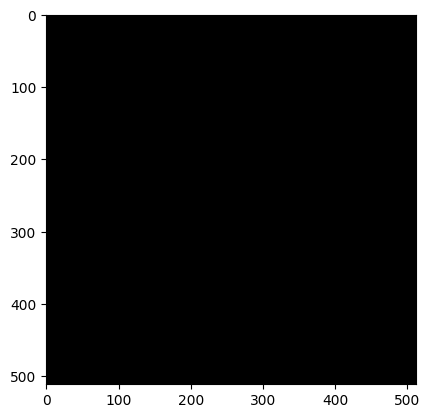

In [21]:
plt.imshow(test_mask, cmap='gray')